In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from sklearn.metrics import r2_score,mean_squared_error
import warnings
from pmdarima.arima import auto_arima
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set()

In [60]:
raw_csv_data = pd.read_csv('1.02 STATION CHITALKHALI.csv')
raw_csv_data.head()
df_comp =raw_csv_data.copy()

In [61]:
df_comp.Date = pd.to_datetime(df_comp.Date, dayfirst = True)
df_comp.set_index("Date",inplace=True)

In [62]:
df_comp = df_comp.asfreq('d') #'d' -> daily

In [63]:
df_comp2 = df_comp.copy()
del df_comp['HIGH']

In [64]:
size = int(len(df_comp)*0.8)
df = df_comp.iloc[:size]
df_test = df_comp.iloc[size:]
df2 = df_comp2.iloc[:size]
df2_test = df_comp2.iloc[size:]

In [65]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [66]:
start_date = "2021-03-14"
end_date = "2021-12-31"

In [67]:
df_comp.head()

,SURFACE PRESSURE,DEW POINT,TEMPERATURE,PRECIPITATION,MAX WIND SPD,RELATIVE HUMIDITY,MIN TEMP,N_ICE EXTENT,S_ICE EXTENT,LOW
Date,,,,,,,,,,
2018-01-01,101.16,15.94,23.65,0.88,4.28,80.56,15.39,12.484,6.384,-1.18509
2018-01-02,101.15,14.30,24.44,0.00,3.04,72.00,14.99,13.764,2.685,-1.58509
2018-01-03,100.97,19.47,30.43,0.03,4.80,72.06,21.49,14.336,2.351,-1.58509
2018-01-04,100.95,20.73,29.30,4.70,4.02,73.25,23.40,14.196,4.930,-1.38509
2018-01-05,100.73,24.30,30.19,19.85,5.97,82.12,25.35,13.054,7.392,-1.13509


In [68]:
mod_auto2 = auto_arima(df.LOW,exogenous = df[['SURFACE PRESSURE','TEMPERATURE',
                                               'MAX WIND SPD','S_ICE EXTENT']]
                       ,m = 15, max_p = 6, max_q = 11)

In [69]:
mod_auto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1168
Model:             SARIMAX(3, 1, 3)x(2, 0, [], 15)   Log Likelihood                  61.155
Date:                             Sat, 26 Mar 2022   AIC                            -96.311
Time:                                     18:21:51   BIC                            -30.502
Sample:                                 01-01-2018   HQIC                           -71.487
                                      - 03-13-2021                                         
Covariance Type:                               opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
SURFACE PRESSURE    -0.1390      0.027     -5.160      0.000      -0.192      -0.086
TEMPERATURE          0.0108      0.003      3.300      0.001       0.004       0.017
MAX WIND SPD         0.0009      0.004      0.226      0.821      -0.007       0.009
S_ICE EXTENT         0.0289      0.003     10.873      0.000       0.024       0.034
ar.L1               -0.3282      0.080     -4.099      0.000      -0.485      -0.171
ar.L2               -0.2021      0.067     -3.021      0.003      -0.333      -0.071
ar.L3                0.4161      0.051      8.192      0.000       0.317       0.516
ma.L1               -0.0292      0.077     -0.382      0.703      -0.179       0.121
ma.L2               -0.1274      0.072     -1.779      0.075      -0.268       0.013
ma.L3               -0.8087      0.074    -10.880      0.000      -0.954      -0.663
ar.S.L15             0.0977      0.026      3.736      0.000       0.046       0.149
ar.S.L30             0.1564      0.021      7.292      0.000       0.114       0.198
sigma2               0.0526      0.001     63.050      0.000       0.051       0.054
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             48859.25
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
df_auto_pred_pr2 = pd.DataFrame(mod_auto2.predict(n_periods = len(df_test[start_date:end_date]),exogenous = df_test[['SURFACE PRESSURE','TEMPERATURE',
                                               'MAX WIND SPD','S_ICE EXTENT']][start_date:end_date]),
                               index = df_test[start_date:end_date].index)

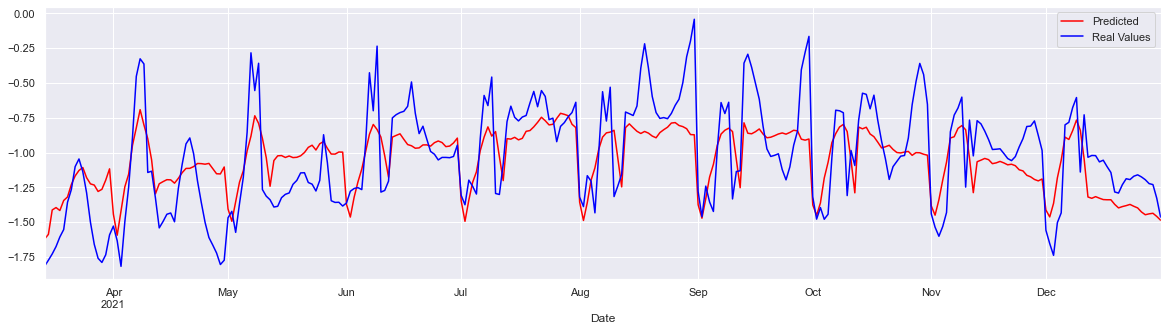

In [71]:
df_auto_pred_pr2[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.LOW[start_date:end_date].plot(color = "blue")
plt.legend(['Predicted', 'Real Values'])

In [72]:
acc =r2_score(df_test.LOW[start_date:end_date],df_auto_pred_pr2[start_date:end_date])
print("Testing Score: ",acc)

Testing Score:  0.47877277210417923
